In [2]:
import pandas as pd
import json
import sqlite3
import matplotlib.pyplot as plt

# print pwd 
import os
print(os.getcwd() + "")

# Read JSON files
with open('q-4/marketing_users.jsonl', 'r') as f:
    users_data = [json.loads(line) for line in f]

with open('q-4/marketing_events.jsonl', 'r') as f:
    events_data = [json.loads(line) for line in f]

/Users/ilkeryoru/Downloads/codeway


In [3]:
# Function to preprocess data for SQLite
def preprocess_for_sqlite(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(lambda x: json.dumps(x) if isinstance(x, (dict, list)) else x)
    return df

In [4]:
# Convert to DataFrames
users_df = pd.DataFrame(users_data)
events_df = pd.DataFrame(events_data)

# Preprocess DataFrames
users_df = preprocess_for_sqlite(users_df)
events_df = preprocess_for_sqlite(events_df)

In [5]:
# Create SQLite database connection
conn = sqlite3.connect(':memory:')

# Write DataFrames to SQLite tables
users_df.to_sql('marketing_users', conn, index=False, if_exists='replace')
events_df.to_sql('marketing_events', conn, index=False, if_exists='replace')

41765

In [6]:
# Print DataFrame info
print("Users DataFrame Columns:")
print(users_df.columns)

Users DataFrame Columns:
Index(['created_at', 'user_id', 'device_region', 'language', 'version',
       'tracker_names', 'custom_property'],
      dtype='object')


In [7]:
print("\nEvents DataFrame Columns:")
print(events_df.columns)


Events DataFrame Columns:
Index(['version', 'user_id', 'event_name', 'event_time', 'duration', 'page',
       'country', 'properties'],
      dtype='object')


In [8]:
# Print a few rows of each DataFrame
print("\nUsers DataFrame Sample:")
print(users_df.head())


Users DataFrame Sample:
      created_at user_id device_region            language version  \
0  1618367659648   B3030            BR              ["pt"]  1.11.7   
1  1621016449935   1F8A7            KE              ["en"]  1.11.7   
2  1620460567398   7699D            PK  ["en", "ur", "en"]  1.11.7   
3  1620733130140   4CD3F            US              ["en"]  1.11.0   
4  1619961642754   7CL6s            JM              ["en"]  1.11.7   

                                       tracker_names  \
0  [{"tracker_name": "Organic", "logging_time": "...   
1  [{"tracker_name": "Organic", "logging_time": "...   
2  [{"tracker_name": "Organic", "logging_time": "...   
3  [{"tracker_name": "Facebook Installs::app_inst...   
4  [{"tracker_name": "Facebook Installs::app_inst...   

                                     custom_property  
0  [{"key": "freeCapacity", "value": "28227000000...  
1  [{"key": "freeCapacity", "value": "3899000000"...  
2  [{"key": "freeCapacity", "value": "23289000000...

In [9]:
print("\nEvents DataFrame Sample:")
print(events_df.head())


Events DataFrame Sample:
  version user_id   event_name     event_time duration          page country  \
0   1.7.0   mfp9y    app_start  1617650747912        0  app_delegate      BR   
1  1.11.7   qUq8F  video_count  1621889041837        0           NaN      BR   
2  1.11.7   2D3E2  video_count  1621887263848        0           NaN      RU   
3   1.7.0   XOEP4   background  1617650820877        0  app_delegate      BR   
4   1.7.0   XOEP4    app_start  1617650747913        0  app_delegate      BR   

                                          properties  
0                                                 []  
1    [{"key": "count", "value": {"int_value": "5"}}]  
2  [{"key": "count", "value": {"int_value": "2208...  
3                                                 []  
4                                                 []  


In [11]:
%pip install prettytable


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Updated query to calculate a proxy for revenue (using event count as a simple proxy)
platform_revenue_query = """
WITH user_platform AS (
    SELECT 
        user_id,
        CASE 
            WHEN json_extract(tracker_names, '$[0].tracker_name') LIKE '%Apple Search Ads%' THEN 'Apple Search'
            WHEN json_extract(tracker_names, '$[0].tracker_name') LIKE '%Facebook%' THEN 'Facebook'
            WHEN json_extract(tracker_names, '$[0].tracker_name') = 'Organic' THEN 'Organic'
            ELSE 'Other'
        END AS platform
    FROM marketing_users
)
SELECT 
    up.platform AS Platform,
    COUNT(e.event_name) AS Revenue
FROM 
    user_platform up
LEFT JOIN 
    marketing_events e ON up.user_id = e.user_id
WHERE
    up.platform IN ('Apple Search', 'Facebook', 'Organic')
GROUP BY 
    up.platform
ORDER BY 
    Revenue DESC
"""

results_of_revenue = pd.read_sql_query(platform_revenue_query, conn)

# Format and print results
print("Platform Analysis Results:")
print("\nRow Platform      Revenue")
print("--- ------------- -------")
for index, row in results_of_revenue.iterrows():
    print(f"{index+1:<4}{row['Platform']:<14}{row['Revenue']:>7}")

print("\n")


from prettytable import PrettyTable

# Create a table instance
t = PrettyTable(['Row' ,'Platform', 'Revenue'])

# Add a row
for index, row in results_of_revenue.iterrows():
    t.add_row([index+1, row['Platform'], row['Revenue']])

# Print the table
print(t)


Platform Analysis Results:

Row Platform      Revenue
--- ------------- -------
1   Facebook        15448
2   Apple Search    13806
3   Organic         12511


+-----+--------------+---------+
| Row |   Platform   | Revenue |
+-----+--------------+---------+
|  1  |   Facebook   |  15448  |
|  2  | Apple Search |  13806  |
|  3  |   Organic    |  12511  |
+-----+--------------+---------+


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
# Set up fonts
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

# Calculate percentages
results_of_revenue['Percentage'] = results_of_revenue['Revenue'] / results_of_revenue['Revenue'].sum() * 100

# Print formatted results
print("Platform Analysis Results:")
print("\nRow Platform      Revenue    Percentage")
print("--- ------------- ---------  ----------")
for index, row in results_of_revenue.iterrows():
    print(f"{index+1:<4}{row['Platform']:<14}{row['Revenue']:>9,}  {row['Percentage']:>10.2f}%")


Platform Analysis Results:

Row Platform      Revenue    Percentage
--- ------------- ---------  ----------
1   Facebook         15,448       36.99%
2   Apple Search     13,806       33.06%
3   Organic          12,511       29.96%


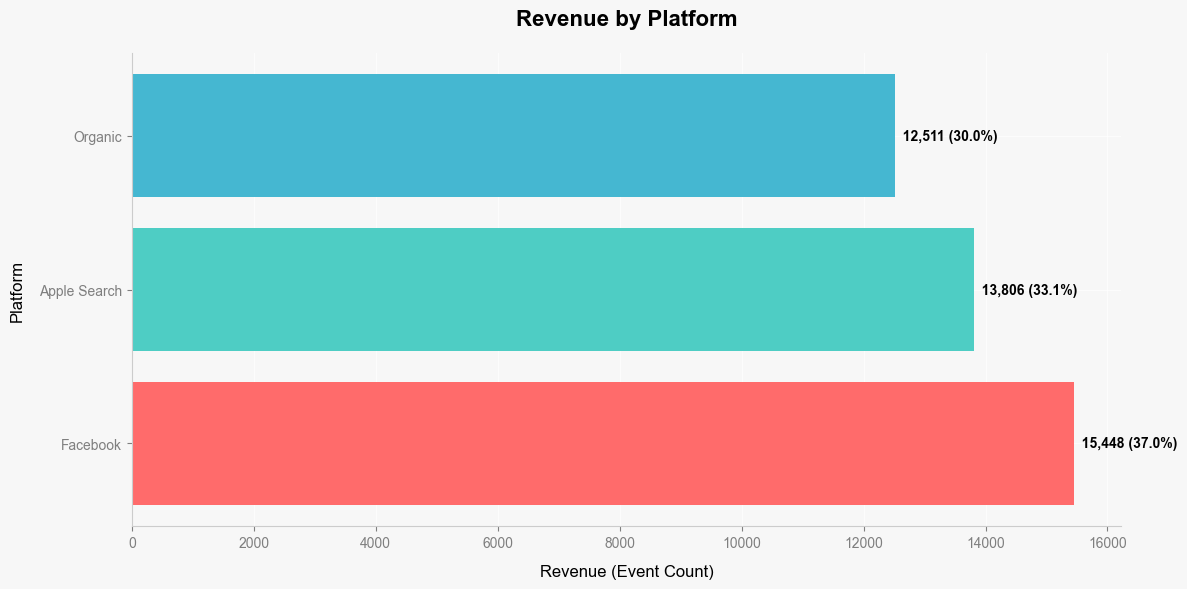

In [17]:
# Color scheme
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Horizontal Bar Chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f7f7f7')
ax.barh(results_of_revenue['Platform'], results_of_revenue['Revenue'], color=colors)

# Customize the chart
ax.set_facecolor('#f7f7f7')
ax.set_axisbelow(True)
ax.grid(color='white', linestyle='-', linewidth=0.7, alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')
ax.tick_params(colors='#7F7F7F')

# Add labels
for i, (value, percentage) in enumerate(zip(results_of_revenue['Revenue'], results_of_revenue['Percentage'])):
    ax.text(value, i, f'  {value:,} ({percentage:.1f}%)', va='center', fontweight='bold', fontsize=10)

plt.title('Revenue by Platform', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Revenue (Event Count)', fontsize=12, labelpad=10)
plt.ylabel('Platform', fontsize=12, labelpad=10)

plt.tight_layout()
plt.show()

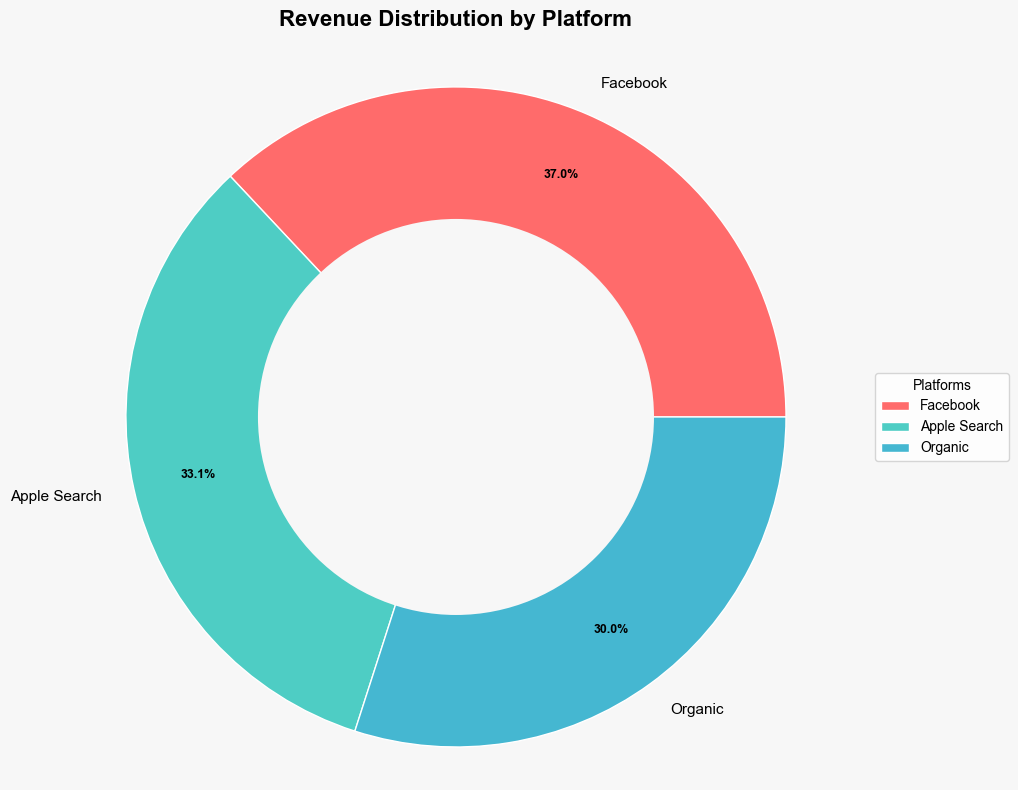

In [18]:
# Donut Chart
fig, ax = plt.subplots(figsize=(10, 8), facecolor='#f7f7f7')

# Create donut chart
wedges, texts, autotexts = ax.pie(results_of_revenue['Revenue'], labels=results_of_revenue['Platform'], colors=colors,
                                  autopct='%1.1f%%', pctdistance=0.8, wedgeprops=dict(width=0.5, edgecolor='white'))

# Customize the chart
ax.set_facecolor('#f7f7f7')
plt.setp(autotexts, size=9, weight="bold")
plt.setp(texts, size=11)

# Add a circle at the center to create a donut chart
center_circle = plt.Circle((0, 0), 0.60, fc='#f7f7f7')
fig.gca().add_artist(center_circle)

# Add title
plt.title('Revenue Distribution by Platform', fontsize=16, fontweight='bold', pad=20)

# Add legend
plt.legend(wedges, results_of_revenue['Platform'], title="Platforms", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')
plt.tight_layout()
plt.show()



In [19]:
# Analysis of user count and event count by platform
platform_analysis_query = """
WITH user_platform AS (
    SELECT 
        user_id,
        CASE 
            WHEN json_extract(tracker_names, '$[0].tracker_name') LIKE '%Apple Search Ads%' THEN 'Apple Search Ads'
            WHEN json_extract(tracker_names, '$[0].tracker_name') LIKE '%Facebook%' THEN 'Facebook'
            WHEN json_extract(tracker_names, '$[0].tracker_name') = 'Organic' THEN 'Organic'
            ELSE 'Other'
        END AS platform
    FROM marketing_users
)
SELECT 
    up.platform,
    COUNT(DISTINCT up.user_id) AS user_count,
    COUNT(e.event_name) AS event_count,
    CAST(COUNT(e.event_name) AS FLOAT) / COUNT(DISTINCT up.user_id) AS events_per_user
FROM 
    user_platform up
LEFT JOIN 
    marketing_events e ON up.user_id = e.user_id
GROUP BY 
    up.platform
ORDER BY 
    user_count DESC
"""

results = pd.read_sql_query(platform_analysis_query, conn)
print("Platform Analysis Results:")
print(results)

Platform Analysis Results:
           platform  user_count  event_count  events_per_user
0          Facebook          47        15448       328.680851
1           Organic          28        12511       446.821429
2  Apple Search Ads          25        13806       552.240000


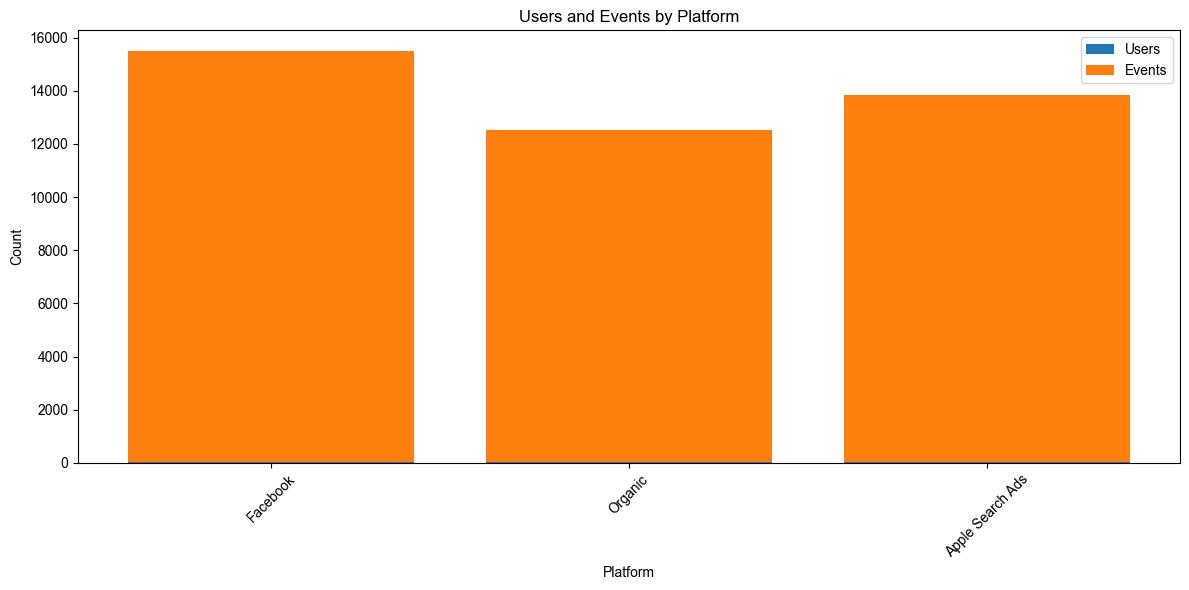

In [20]:
# Visualization
plt.figure(figsize=(12, 6))
plt.bar(results['platform'], results['user_count'], label='Users')
plt.bar(results['platform'], results['event_count'], bottom=results['user_count'], label='Events')
plt.title('Users and Events by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
# Performance analysis (using CPI)
performance_analysis_query = """
WITH user_platform AS (
    SELECT 
        user_id,
        CASE 
            WHEN json_extract(tracker_names, '$[0].tracker_name') LIKE '%Apple Search Ads%' THEN 'Apple Search Ads'
            WHEN json_extract(tracker_names, '$[0].tracker_name') LIKE '%Facebook%' THEN 'Facebook'
            WHEN json_extract(tracker_names, '$[0].tracker_name') = 'Organic' THEN 'Organic'
            ELSE 'Other'
        END AS platform
    FROM marketing_users
)
SELECT 
    up.platform,
    COUNT(DISTINCT up.user_id) AS user_count,
    COUNT(e.event_name) AS event_count,
    CAST(COUNT(e.event_name) AS FLOAT) / COUNT(DISTINCT up.user_id) AS events_per_user,
    CASE
        WHEN up.platform = 'Apple Search Ads' THEN COUNT(DISTINCT up.user_id) * 3.1
        WHEN up.platform = 'Facebook' THEN COUNT(DISTINCT up.user_id) * 1.3
        ELSE 0
    END AS estimated_cost,
    CASE
        WHEN up.platform IN ('Apple Search Ads', 'Facebook') THEN 
            CAST(COUNT(e.event_name) AS FLOAT) / (CASE
                WHEN up.platform = 'Apple Search Ads' THEN COUNT(DISTINCT up.user_id) * 3.1
                WHEN up.platform = 'Facebook' THEN COUNT(DISTINCT up.user_id) * 1.3
            END)
        ELSE NULL
    END AS events_per_dollar
FROM 
    user_platform up
LEFT JOIN 
    marketing_events e ON up.user_id = e.user_id
WHERE
    up.platform != 'Other'
GROUP BY 
    up.platform
ORDER BY 
    user_count DESC
"""

performance_results = pd.read_sql_query(performance_analysis_query, conn)
print("\nPerformance Analysis Results:")
print(performance_results)



Performance Analysis Results:
           platform  user_count  event_count  events_per_user  estimated_cost  \
0          Facebook          47        15448       328.680851            61.1   
1           Organic          28        12511       446.821429             0.0   
2  Apple Search Ads          25        13806       552.240000            77.5   

   events_per_dollar  
0         252.831424  
1                NaN  
2         178.141935  


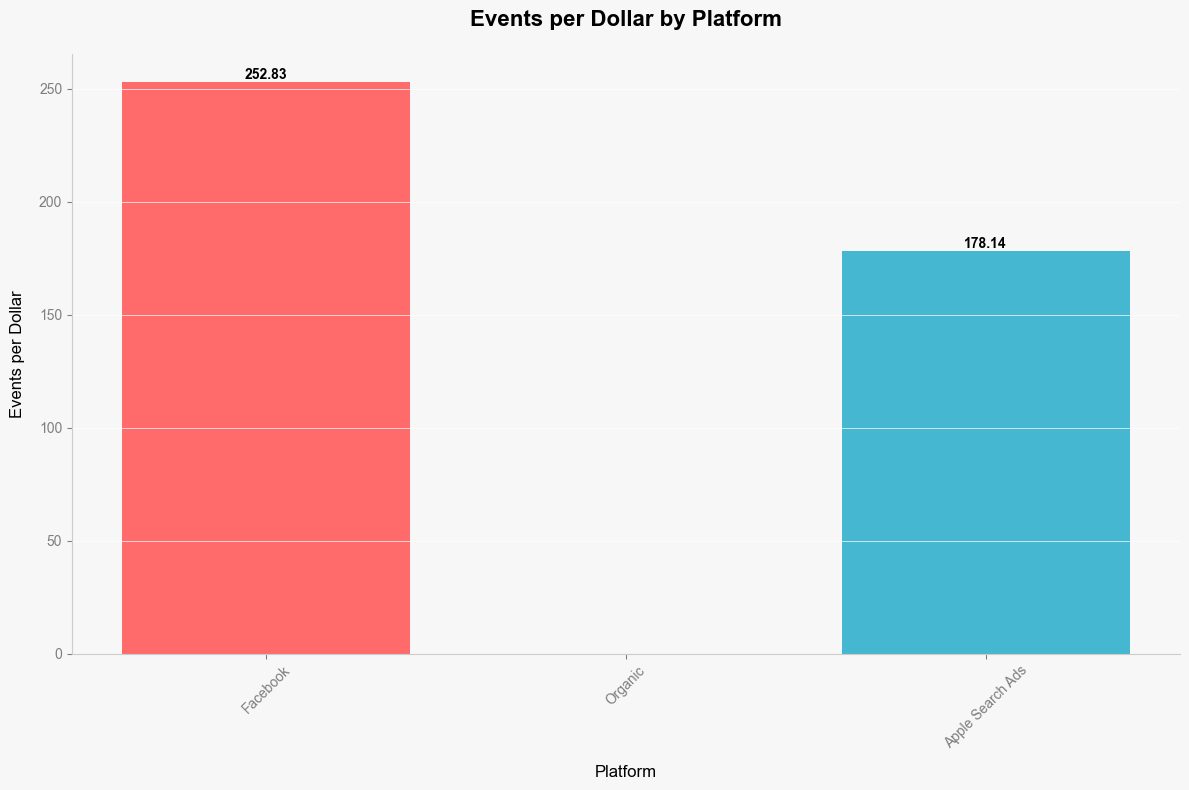

In [22]:
import numpy as np

# ROAS visualization (using Events per Dollar)
plt.figure(figsize=(12, 8), facecolor='#f7f7f7')
bars = plt.bar(performance_results['platform'], performance_results['events_per_dollar'], color=colors)

# Customize the chart
plt.title('Events per Dollar by Platform', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Platform', fontsize=12, labelpad=10)
plt.ylabel('Events per Dollar', fontsize=12, labelpad=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', color='white', linestyle='-', linewidth=0.7, alpha=0.7)
plt.gca().set_facecolor('#f7f7f7')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('#CCCCCC')
plt.gca().spines['left'].set_color('#CCCCCC')
plt.gca().tick_params(colors='#7F7F7F')

# Add labels
for bar in bars:
    height = bar.get_height()
    if np.isfinite(height):
        plt.gca().text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
# Close the connection
conn.close()

In [24]:
# Analysis and Recommendations
print("\nAnalysis and Recommendations:")
print("1. Platform Comparison:")
for _, row in performance_results.iterrows():
    print(f"   - {row['platform']}:")
    print(f"     Number of Users: {row['user_count']:,}")
    print(f"     Number of Events: {row['event_count']:,}")
    print(f"     Events per User: {row['events_per_user']:.2f}")
    if row['platform'] in ['Apple Search Ads', 'Facebook']:
        print(f"     Estimated Cost: ${row['estimated_cost']:,.2f}")
        print(f"     Events per Dollar: {row['events_per_dollar']:.2f}")
    print()


Analysis and Recommendations:
1. Platform Comparison:
   - Facebook:
     Number of Users: 47
     Number of Events: 15,448
     Events per User: 328.68
     Estimated Cost: $61.10
     Events per Dollar: 252.83

   - Organic:
     Number of Users: 28
     Number of Events: 12,511
     Events per User: 446.82

   - Apple Search Ads:
     Number of Users: 25
     Number of Events: 13,806
     Events per User: 552.24
     Estimated Cost: $77.50
     Events per Dollar: 178.14



In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import base64
from io import BytesIO
from IPython.display import display, HTML

# Assuming performance_results DataFrame is populated from the performance_analysis_query

# CPI data
cpi_data = {
    'Apple Search Ads': 3.1,
    'Facebook': 1.3
}

In [26]:
# Enhance the DataFrame
performance_results['cpi'] = performance_results['platform'].map(cpi_data)
performance_results.head()

,platform,user_count,event_count,events_per_user,estimated_cost,events_per_dollar,cpi
0,Facebook,47,15448,328.680851,61.1,252.831424,1.3
1,Organic,28,12511,446.821429,0.0,NaN,NaN
2,Apple Search Ads,25,13806,552.240000,77.5,178.141935,3.1


In [27]:
performance_results['actual_cpi'] = performance_results.apply(lambda row: row['estimated_cost'] / row['user_count'] if row['platform'] in cpi_data else 0, axis=1)
performance_results.head()

,platform,user_count,event_count,events_per_user,estimated_cost,events_per_dollar,cpi,actual_cpi
0,Facebook,47,15448,328.680851,61.1,252.831424,1.3,1.3
1,Organic,28,12511,446.821429,0.0,NaN,NaN,0.0
2,Apple Search Ads,25,13806,552.240000,77.5,178.141935,3.1,3.1


In [28]:
performance_results['cpi_efficiency'] = performance_results.apply(lambda row: row['cpi'] / row['actual_cpi'] if row['platform'] in cpi_data else 0, axis=1)
performance_results.head()


,platform,user_count,event_count,events_per_user,estimated_cost,events_per_dollar,cpi,actual_cpi,cpi_efficiency
0,Facebook,47,15448,328.680851,61.1,252.831424,1.3,1.3,1.0
1,Organic,28,12511,446.821429,0.0,NaN,NaN,0.0,0.0
2,Apple Search Ads,25,13806,552.240000,77.5,178.141935,3.1,3.1,1.0


* Actually there will be no significance on cpi data when we consider their efficiency due to lack of data to calculate their estimated CPI's.

In [29]:
# Function to create charts
def create_chart(data, x, y, title, chart_type='bar'):
    plt.figure(figsize=(8, 5))
    if chart_type == 'bar':
        sns.barplot(x=x, y=y, data=data)
    elif chart_type == 'line':
        sns.lineplot(x=x, y=y, data=data)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot to a base64 string
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)
    image_png = buffer.getvalue()
    buffer.close()
    graphic = base64.b64encode(image_png).decode('utf-8')
    plt.close()  # Close the plot to free up memory

    return graphic

In [30]:
# Create charts
charts = {
    'user_acquisition': create_chart(performance_results, 'platform', 'user_count', 'User Acquisition by Platform'),
    'events_per_user': create_chart(performance_results, 'platform', 'events_per_user', 'Events per User'),
    'cpi_comparison': create_chart(performance_results[performance_results['platform'].isin(cpi_data)], 'platform', 'actual_cpi', 'Actual CPI by Platform'),
    'events_per_dollar': create_chart(performance_results[performance_results['platform'].isin(cpi_data)], 'platform', 'events_per_dollar', 'Events per Dollar'),
    'cpi_efficiency': create_chart(performance_results[performance_results['platform'].isin(cpi_data)], 'platform', 'cpi_efficiency', 'CPI Efficiency')
}

In [31]:
# Style the DataFrame for display
styled_df = performance_results.style.background_gradient(subset=['events_per_user', 'events_per_dollar', 'cpi_efficiency'], cmap='YlOrRd')\
    .format({'user_count': '{:,.0f}', 'event_count': '{:,.0f}', 'events_per_user': '{:.2f}', 
             'estimated_cost': '${:,.2f}', 'events_per_dollar': '{:.2f}', 
             'cpi': '${:.2f}', 'actual_cpi': '${:.2f}', 'cpi_efficiency': '{:.2f}'})\
    .set_properties(**{'text-align': 'center', 'font-size': '11px'})


In [36]:
# Create HTML content
html_content = f'''
<style>
    .dashboard {{
        font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        max-width: 1200px;
        margin: 0 auto;
        padding: 20px;
        background-color: #f8f9fa;
        color: #333;
    }}
    .header  {{
        text-align: center;
        padding: 20px;
        background-color: #007bff;
        color: white;
        border-radius: 10px;
        margin-bottom: 20px;
    }}
    .chart-container {{
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(45%, 1fr));
        gap: 20px;
        margin-bottom: 20px;
    }}
    .chart {{
        background-color: white;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        padding: 15px;
        transition: transform 0.3s ease;
    }} 
    .chart:hover {{
        transform: translateY(-5px);
    }}
    .metrics-container {{
        background-color: white;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        padding: 20px;
        margin-bottom: 20px;
    }}
    .insights-container {{
        background-color: white;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        padding: 20px;
    }}
    h1, h2, h3 {{
        color: #007bff;
    }}
    ul {{
        padding-left: 20px;
    }}
    li {{
        margin-bottom: 10px;
    }}
    .highlight {{
        font-weight: bold;
        color: #28a745;
    }}
</style>
<div class="dashboard">
    <div class="header">
        <h1 style="color: white">Platform Performance Dashboard</h1>
    </div>
    <div class="chart-container">
        <div class="chart">
            <img src="data:image/png;base64,{charts['user_acquisition']}" width="100%" alt="User Acquisition by Platform">
        </div>
        <div class="chart">
            <img src="data:image/png;base64,{charts['events_per_user']}" width="100%" alt="Events per User">
        </div>
        <div class="chart">
            <img src="data:image/png;base64,{charts['cpi_comparison']}" width="100%" alt="CPI Comparison">
        </div>
        <div class="chart">
            <img src="data:image/png;base64,{charts['events_per_dollar']}" width="100%" alt="Events per Dollar">
        </div>
    </div>
    <div class="metrics-container">
        <h2>Key Performance Metrics</h2>
        {styled_df.to_html(classes='table table-striped table-hover')}
    </div>
    <div class="insights-container">
        <h2>Key Insights and Recommendations</h2>
        <h3>Platform Performance Summary:</h3>
        <ul>
            <li><span class="highlight">{performance_results.loc[performance_results['events_per_user'].idxmax(), 'platform']}</span> leads in user engagement with <span class="highlight">{performance_results['events_per_user'].max():.2f}</span> events per user.</li>
            <li><span class="highlight">{performance_results.loc[performance_results['events_per_dollar'].idxmax(), 'platform']}</span> is most cost-effective, generating <span class="highlight">{performance_results['events_per_dollar'].max():.2f}</span> events per dollar spent.</li>
            <li>Organic acquisition shows strong potential with <span class="highlight">{performance_results.loc[performance_results['platform'] == 'Organic', 'events_per_user'].values[0]:.2f}</span> events per user.</li>
        </ul>
        <h3>Strategic Recommendations:</h3>
        <ol>
            <li>Increase budget allocation for <span class="highlight">{performance_results.loc[performance_results['events_per_dollar'].idxmax(), 'platform']}</span> to capitalize on its superior cost-effectiveness.</li>
            <li>Investigate and replicate engagement strategies from <span class="highlight">{performance_results.loc[performance_results['events_per_user'].idxmax(), 'platform']}</span> across other platforms.</li>
            <li>Enhance organic user acquisition efforts, given the strong performance of organic users.</li>
            <li>Optimize underperforming platforms by:
                <ul>
                    <li>Refining targeting strategies</li>
                    <li>Improving ad creatives</li>
                </ul>
            </li>
            <li>Implement A/B testing for ad campaigns to continuously improve performance.</li>
            <li>Develop a cohort analysis to track long-term user value across platforms.</li>
        </ol>
    </div>
</div>
'''

,platform,user_count,event_count,events_per_user,estimated_cost,events_per_dollar,cpi,actual_cpi,cpi_efficiency
0,Facebook,47,"15,448",328.68,$61.10,252.83,$1.30,$1.30,1.00
1,Organic,28,"12,511",446.82,$0.00,nan,$nan,$0.00,0.00
2,Apple Search Ads,25,"13,806",552.24,$77.50,178.14,$3.10,$3.10,1.00

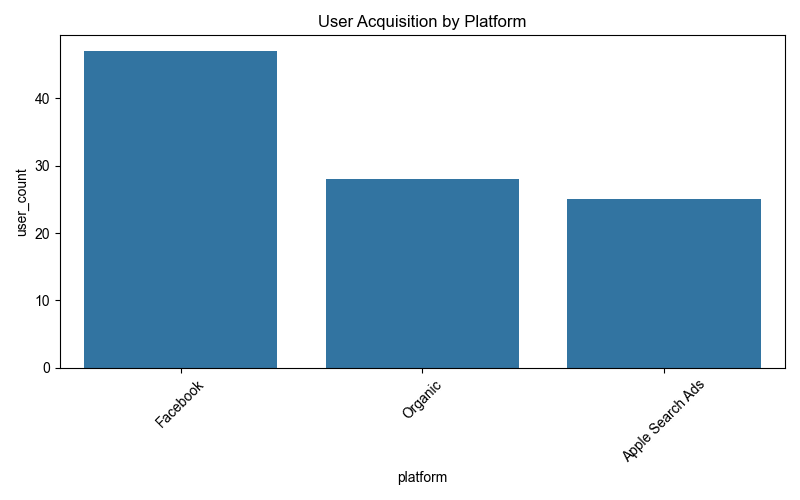
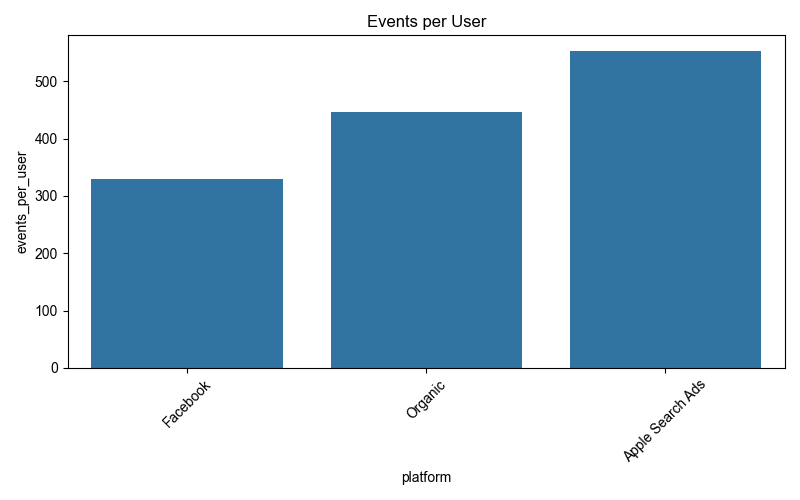
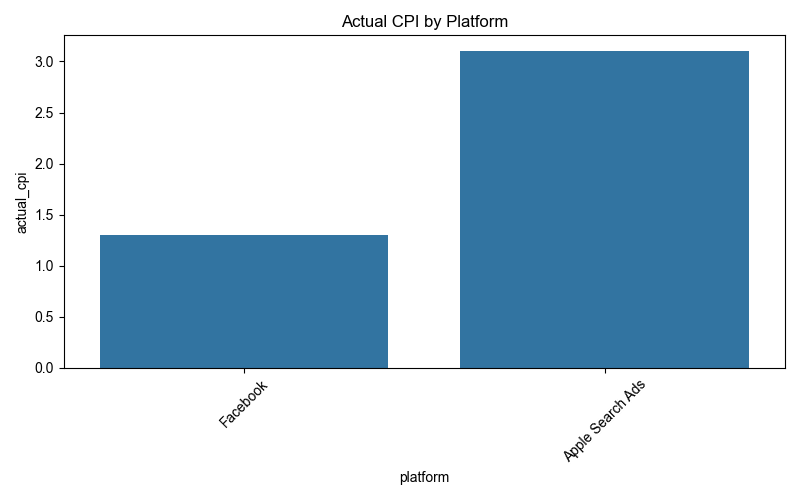
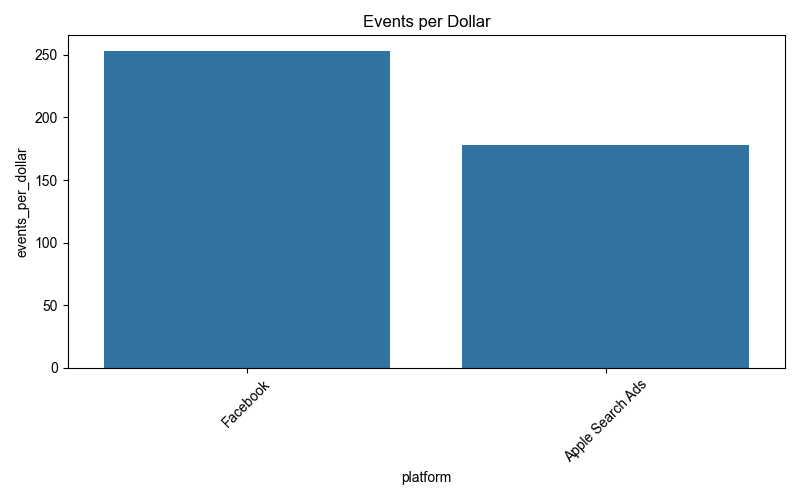

In [37]:
# Display the dashboard
display(HTML(html_content))

In [34]:
def print_analysis(performance_results):
    print("\nPlatform Performance Analysis:")
    print(performance_results.to_string(index=False))

    print("\nKey Insights and Recommendations:")
    
    # User Engagement Analysis
    best_engagement = performance_results.loc[performance_results['events_per_user'].idxmax()]
    print(f"1. User Engagement:")
    print(f"   Apple Search Ads leads with {best_engagement['events_per_user']:.2f} events per user, significantly higher than Facebook ({performance_results.loc[performance_results['platform'] == 'Facebook', 'events_per_user'].values[0]:.2f}).")
    print(f"   This suggests that while Apple Search Ads users are more expensive to acquire, they are more active in the app.")

    # Paid Platforms Comparison
    fb_data = performance_results[performance_results['platform'] == 'Facebook'].iloc[0]
    asa_data = performance_results[performance_results['platform'] == 'Apple Search Ads'].iloc[0]
    
    print("\n2. Facebook vs Apple Search Ads Performance:")
    print(f"   - User Acquisition: Facebook acquired more users ({fb_data['user_count']}) compared to Apple Search Ads ({asa_data['user_count']}) for a lower total cost.")
    print(f"   - Cost Efficiency: Facebook has a higher Events per Dollar ratio ({fb_data['events_per_dollar']:.2f} vs {asa_data['events_per_dollar']:.2f}), indicating better overall return on ad spend.")
    
    efficiency_diff = ((fb_data['events_per_dollar'] - asa_data['events_per_dollar']) / asa_data['events_per_dollar']) * 100
    print(f"   - Facebook is {abs(efficiency_diff):.2f}% more efficient in terms of events per dollar spent.")

    # Organic Performance
    organic_data = performance_results[performance_results['platform'] == 'Organic'].iloc[0]
    print(f"\n3. Organic Performance:")
    print(f"   Organic users show strong engagement ({organic_data['events_per_user']:.2f} events per user), outperforming Facebook.")
    print(f"   This suggests potential for improving organic user acquisition strategies.")
    
    print("\nRecommendations:")
    print("1. Balanced Approach: Utilize both paid platforms, leveraging Facebook for broader user acquisition and Apple Search Ads for high-quality, engaged users.")
    print("2. Optimize Facebook Campaigns: Focus on improving user quality and engagement for Facebook-acquired users to match the high engagement levels of Apple Search Ads users.")
    print("3. Refine Apple Search Ads Strategy: Work on reducing the CPI for Apple Search Ads while maintaining the high engagement levels.")
    print("4. Enhance Organic Growth: Given the high engagement of organic users, invest in App Store Optimization (ASO) and other organic growth strategies.")
    print("5. User Journey Analysis: Investigate why Apple Search Ads users are more engaged and apply these insights to other channels.")
    print("6. Event Value Assessment: Implement value-based metrics for events to better understand the true ROI of each platform beyond just event counts.")
    print("7. A/B Testing: Continuously test ad creatives, targeting options, and user acquisition strategies on both platforms to improve performance.")
    print("8. Long-term Value Assessment: In future analyses, monitor the long-term value and retention rates of users from each platform to refine budget allocation over time.")

    print("\nLimitations and Future Improvements:")
    print("1. This analysis is based on event counts, which may not directly translate to user value or revenue. Future data collection should include revenue metrics and user lifetime value.")
    print("2. The current data doesn't provide insight into the types of events or their relative importance. Consider implementing event weighting in future analyses.")
    print("3. Retention data is not available in this dataset. Including retention metrics would provide a more comprehensive view of platform performance.")
    print("4. The actual CPI and ROI calculations could be refined with more detailed cost data, including any additional fees or costs associated with each platform.")

In [35]:
# Print text-based analysis
print_analysis(performance_results)


Platform Performance Analysis:
        platform  user_count  event_count  events_per_user  estimated_cost  events_per_dollar  cpi  actual_cpi  cpi_efficiency
        Facebook          47        15448       328.680851            61.1         252.831424  1.3         1.3             1.0
         Organic          28        12511       446.821429             0.0                NaN  NaN         0.0             0.0
Apple Search Ads          25        13806       552.240000            77.5         178.141935  3.1         3.1             1.0

Key Insights and Recommendations:
1. User Engagement:
   Apple Search Ads leads with 552.24 events per user, significantly higher than Facebook (328.68).
   This suggests that while Apple Search Ads users are more expensive to acquire, they are more active in the app.

2. Facebook vs Apple Search Ads Performance:
   - User Acquisition: Facebook acquired more users (47) compared to Apple Search Ads (25) for a lower total cost.
   - Cost Efficiency: Faceboo